<a href="https://colab.research.google.com/github/avikumart/LLM-GenAI-Transformers-Notebooks/blob/main/DeepLearningFiles/CNN_image_classification_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import cv2
from tqdm import tqdm
from sklearn.utils import shuffle
from skimage.io import imread, imshow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
os.chdir("/content/drive/MyDrive/GL_Deeplearning_notebooks/CV_w1/")

In [7]:
!ls

casestudy_flowers_classifier.ipynb  Duck_image.jpg  flowers.zip     Week1.ipynb
classifier.h5			    flowers	    my_model.keras


In [10]:
# Load the dataset
train_dir = "/content/drive/MyDrive/GL_Deeplearning_notebooks/CV_w1/flowers/train"
test_dir = "/content/drive/MyDrive/GL_Deeplearning_notebooks/CV_w1/flowers/test"

# image classes
classes = os.listdir(train_dir)
print(classes)

# assing class labels
class_labels = {cls: idx for idx, cls in enumerate(classes)}
print(class_labels)

['tulip', 'daisy', 'dandelion', 'rose', 'sunflower']
{'tulip': 0, 'daisy': 1, 'dandelion': 2, 'rose': 3, 'sunflower': 4}


In [12]:
train_image = []
train_label = []

for folder in os.listdir(train_dir):
    label = class_labels[folder]
    for file in tqdm(os.listdir(os.path.join(train_dir, folder))):
        img_path = os.path.join(train_dir, folder, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        train_image.append(img)
        train_label.append(label)

100%|██████████| 634/634 [00:12<00:00, 48.79it/s] 


In [13]:
len(train_image), len(train_label)

(3823, 3823)

In [15]:
test_image = []
test_label = []

for folder in os.listdir(test_dir):
    label = class_labels[folder]
    for file in tqdm(os.listdir(os.path.join(test_dir, folder))):
        img_path = os.path.join(test_dir, folder, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        test_image.append(img)
        test_label.append(label)

100%|██████████| 100/100 [00:02<00:00, 47.73it/s]


In [19]:
# print the shape of the training and test data
print("Training data shape:", np.array(train_image).shape)
print("Training label shape:", np.array(train_label).shape)

print("Test data shape:", np.array(test_image).shape)
print("Test label shape:", np.array(test_label).shape)

Training data shape: (3823, 64, 64, 3)
Training label shape: (3823,)
Test data shape: (500, 64, 64, 3)
Test label shape: (500,)


In [20]:
# shuffle the train nad test datasets
(train_images, train_labels) = shuffle(np.array(train_image), np.array(train_label), random_state=45)
(test_images, test_labels) = shuffle(np.array(test_image), np.array(test_label), random_state=45)

In [21]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((3823, 64, 64, 3), (3823,), (500, 64, 64, 3), (500,))

In [22]:
# normalise the image and convert it into a tensor dataset
train_images = train_images.astype("float32") / 255.0
test_images = test_images.astype("float32") / 255.0

# tensor dataset
train = torch.utils.data.TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
test = torch.utils.data.TensorDataset(torch.from_numpy(test_images), torch.from_numpy(test_labels))

# pytorch tensor dataloader
train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False)

In [48]:
# build the pytorch model
n_iters = 5000
n_epochs = n_iters / (len(train_images) / 32)
epochs = int(n_epochs)
print("No of epochs:", epochs)

No of epochs: 41


In [49]:
class CNNmodel(nn.Module):
  def __init__(self):
    super(CNNmodel, self).__init__()
    # convolution block
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    # convolution block 2
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # convolution bloack 3 to reduce the channels and flatten the channels
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
    self.relu3 = nn.ReLU()
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(in_features=64*8*8, out_features=128)
    self.relu4 = nn.ReLU()

    # output layer
    self.fc2 = nn.Linear(in_features=128, out_features=5)

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = self.relu3(x)
    x = self.pool3(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.relu4(x)
    x = self.fc2(x)
    return x

In [50]:
# Create model
model = CNNmodel()

# create loss
loss_fn = nn.CrossEntropyLoss()

# create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [51]:
model.cuda()

CNNmodel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)

In [52]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("GPU not available, using CPU")

GPU is available
Device name: Tesla T4


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [54]:
count = 0
iter_li = []
acc_li = []
loss_li = []
for epoch in range(epochs):
  for i, (images,labels) in enumerate(train_loader):

     image = Variable(images.view(images.shape[0],3,64,64))
     label = Variable(labels)

     if torch.cuda.is_available():
       image = image.cuda()
       label = label.cuda()

     # initiate the optim
     optimizer.zero_grad()
     # train the model
     output = model(image)
     loss = loss_fn(output,label)
     loss.backward()
     optimizer.step()
     count += 1

     if count % 50 == 0:
       correct = 0
       total = 0
       for images,labels in test_loader:
         image = Variable(images.view(images.shape[0],3,64,64))
         label = Variable(labels)
         if torch.cuda.is_available():
           image = image.cuda()
           label = label.cuda()
         output = model(image)
         _,predicted = torch.max(output.data,1)
         total += label.size(0)
         correct += (predicted == label).sum()
       iter_li.append(count)
       acc_li.append(100*correct/total)
       loss_li.append(loss.data)
     if count % 100 == 0:
      print('Iteration: {}. Loss: {}. Accuracy: {}'.format(count, loss.data, 100*correct/total))

Iteration: 100. Loss: 1.5737565755844116. Accuracy: 22.200000762939453
Iteration: 200. Loss: 1.2252388000488281. Accuracy: 33.60000228881836
Iteration: 300. Loss: 1.5721921920776367. Accuracy: 40.20000076293945
Iteration: 400. Loss: 1.6798710823059082. Accuracy: 45.20000076293945
Iteration: 500. Loss: 1.4960287809371948. Accuracy: 41.20000076293945
Iteration: 600. Loss: 0.9203051328659058. Accuracy: 45.400001525878906
Iteration: 700. Loss: 1.252207636833191. Accuracy: 46.60000228881836
Iteration: 800. Loss: 1.0891200304031372. Accuracy: 52.60000228881836
Iteration: 900. Loss: 1.0177085399627686. Accuracy: 51.20000076293945
Iteration: 1000. Loss: 0.9849663972854614. Accuracy: 53.000003814697266
Iteration: 1100. Loss: 1.086504340171814. Accuracy: 51.400001525878906
Iteration: 1200. Loss: 1.1022870540618896. Accuracy: 53.000003814697266
Iteration: 1300. Loss: 0.9334267377853394. Accuracy: 50.400001525878906
Iteration: 1400. Loss: 0.6841486096382141. Accuracy: 54.000003814697266
Iteration:

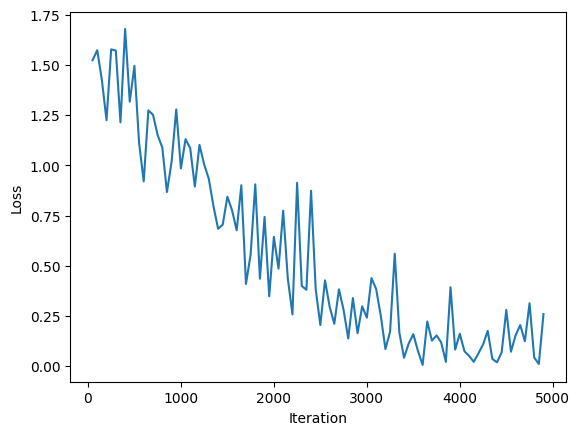

In [59]:
# visualize the iteration and loss
plt.plot(np.array(iter_li), np.array([loss.cpu().detach().numpy() for loss in loss_li]))
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

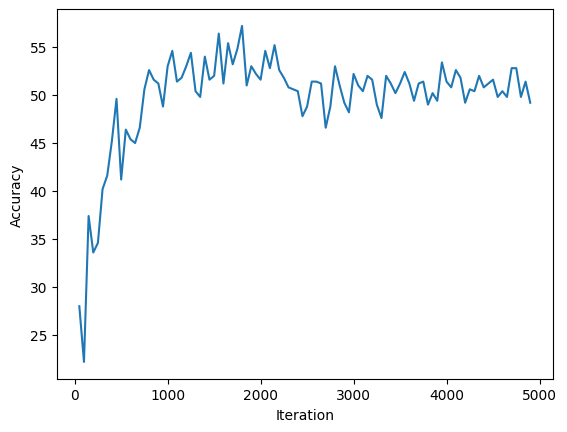

In [62]:
# visualize the iteration with accuracy
plt.plot(np.array(iter_li), np.array([acc.cpu().detach().numpy() for acc in acc_li]))
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [72]:
# predict of test data
if torch.no_grad():
  images = Variable(torch.Tensor(test_loader.dataset[0][0].view(1,3,64,64))).cuda()
  labels = Variable(torch.Tensor(test_labels)).cuda()
  preds = model(images)
  _,predicted = torch.max(preds.data,1)
  accuracy = np.sum(predicted.cpu().numpy() == labels.cpu().numpy()) / len(labels)
  print("Accuracy:", accuracy)

Accuracy: 0.2
